### Trying GPy
    - plotting issue using plotly
    - GPLVM and Bayesian GPLVM
    - how optimization works in both cases?
    - what makes it Bayesian ?
    - what is the improvement for Bayesian approach
    - how can it be extended

In [39]:
import numpy as np
import pymc as pm
import GPy 
import matplotlib.pyplot as plt

In [5]:
# Define dataset 
N = 100
k1 = GPy.kern.RBF(5, variance=1, lengthscale=1./np.random.dirichlet(np.r_[10,10,10,0.1,0.1]), ARD=True)
k2 = GPy.kern.RBF(5, variance=1, lengthscale=1./np.random.dirichlet(np.r_[10,0.1,10,0.1,10]), ARD=True)
k3 = GPy.kern.RBF(5, variance=1, lengthscale=1./np.random.dirichlet(np.r_[0.1,0.1,10,10,10]), ARD=True)
X = np.random.normal(0, 1, (N, 5))
A = np.random.multivariate_normal(np.zeros(N), k1.K(X), 10).T
B = np.random.multivariate_normal(np.zeros(N), k2.K(X), 10).T
C = np.random.multivariate_normal(np.zeros(N), k3.K(X), 10).T

Y = np.vstack((A,B,C))
labels = np.hstack((np.zeros(A.shape[0]), np.ones(B.shape[0]), np.ones(C.shape[0])*2))

input_dim = 2 # How many latent dimensions to use
kernel = GPy.kern.RBF(input_dim, 1, ARD=True) 


In [17]:
A.shape, B.shape, C.shape, Y.shape

((100, 10), (100, 10), (100, 10), (300, 10))

In [29]:
from sklearn.decomposition import PCA

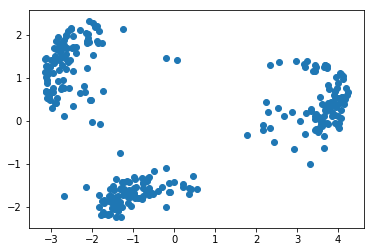

In [31]:
pca= PCA(n_components=2)
y_test = pca.fit_transform(Y)

plt.scatter(y_test[:,0], y_test[:,1])

In [32]:
Q = input_dim
m_gplvm = GPy.models.GPLVM(Y, Q, kernel=GPy.kern.RBF(Q))
m_gplvm.kern.lengthscale = .2
m_gplvm.kern.variance = 1
m_gplvm.likelihood.variance = 1.
#m2.likelihood.variance.fix(.1)
m_gplvm

GPLVM.,value,constraints,priors
latent_mean,"(300, 2)",,
rbf.variance,1.0,+ve,
rbf.lengthscale,0.2,+ve,
Gaussian_noise.variance,1.0,+ve,


In [33]:
m_gplvm.optimize(messages=1, max_iters=5e4)

Widget Javascript not detected.  It may not be installed or enabled properly.


### Trying PyMC implementation
    - how it performs optimization
    - uses trace ? what does it mean
    - how can it be extended?

In [1]:
import sys

import pymc3 as pm
import theano.tensor as tt
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

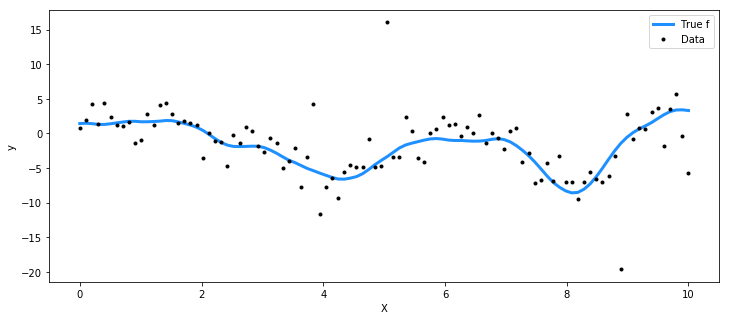

In [29]:
# set the seed
np.random.seed(1)

n = 100 # The number of data points
X = np.linspace(0, 10, n)[:, None] # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
ℓ_true = 1.0
η_true = 3.0
cov_func = η_true**2 * pm.gp.cov.Matern52(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(mean_func(X).eval(),
                                       cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()

# The observed data is the latent function plus a small amount of T distributed noise
# The standard deviation of the noise is `sigma`, and the degrees of freedom is `nu`
σ_true = 2.0
ν_true = 3.0
y = f_true + σ_true * np.random.standard_t(ν_true, size=n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f");
ax.plot(X, y, 'ok', ms=3, label="Data");
ax.set_xlabel("X"); ax.set_ylabel("y"); plt.legend();

In [27]:
# with pm.Model() as model:
#     ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
#     η = pm.HalfCauchy("η", beta=5)

#     cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
#     gp = pm.gp.Latent(cov_func=cov)

#     f = gp.prior("f", X=X)
    
#     σ = pm.HalfCauchy("σ", beta=5)
#     ν = pm.Gamma("ν", alpha=2, beta=0.1)
#     y_ = pm.StudentT("y", mu=f, lam=1.0/σ, nu=ν, observed=y)
#     print("here")
#     trace = pm.sample(10)

In [30]:
print(X.shape)

(100, 1)


In [97]:
with pm.Model() as model:
    X_ = pm.Normal("X", mu = X.mean(), sd = X.std(), shape = 100, observed= True)
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)

    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.Latent(cov_func=cov)

    f = gp.prior("f", X=X)
    
    σ = pm.HalfCauchy("σ", beta=5)
    ν = pm.Gamma("ν", alpha=2, beta=0.1)
    y_ = pm.StudentT("y", mu=f, lam=1.0/σ, nu=ν, observed=y)
    print("here")
    trace = pm.sample(10, tune = 10)

Only 10 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


here


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν, σ, f_rotated_, η, ℓ]
Sampling 2 chains: 100%|██████████| 40/40 [00:17<00:00,  2.26draws/s]
/home/arnav/miniconda3/lib/python3.6/site-packages/pymc3/sampling.py:466: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


In [111]:
with model:
    pred_samples = pm.sample_posterior_predictive(trace, vars=[X_], samples=1000, size = 1000)


print(pred_samples['X'].shape)
dat_mean, dat_std = pred_samples['X'].mean(),pred_samples['X'].std()
(dat_mean,dat_std) ,(X.mean(), X.std())

100%|██████████| 1000/1000 [00:00<00:00, 2006.94it/s]


(1000, 1000)


((5.002411227111469, 2.914302863759382), (5.0, 2.9157646512850626))

^^ the above shows that we can resample the input

how to do it given the params?

write the marginal of X in terms of Y and set Y=observed and try if time

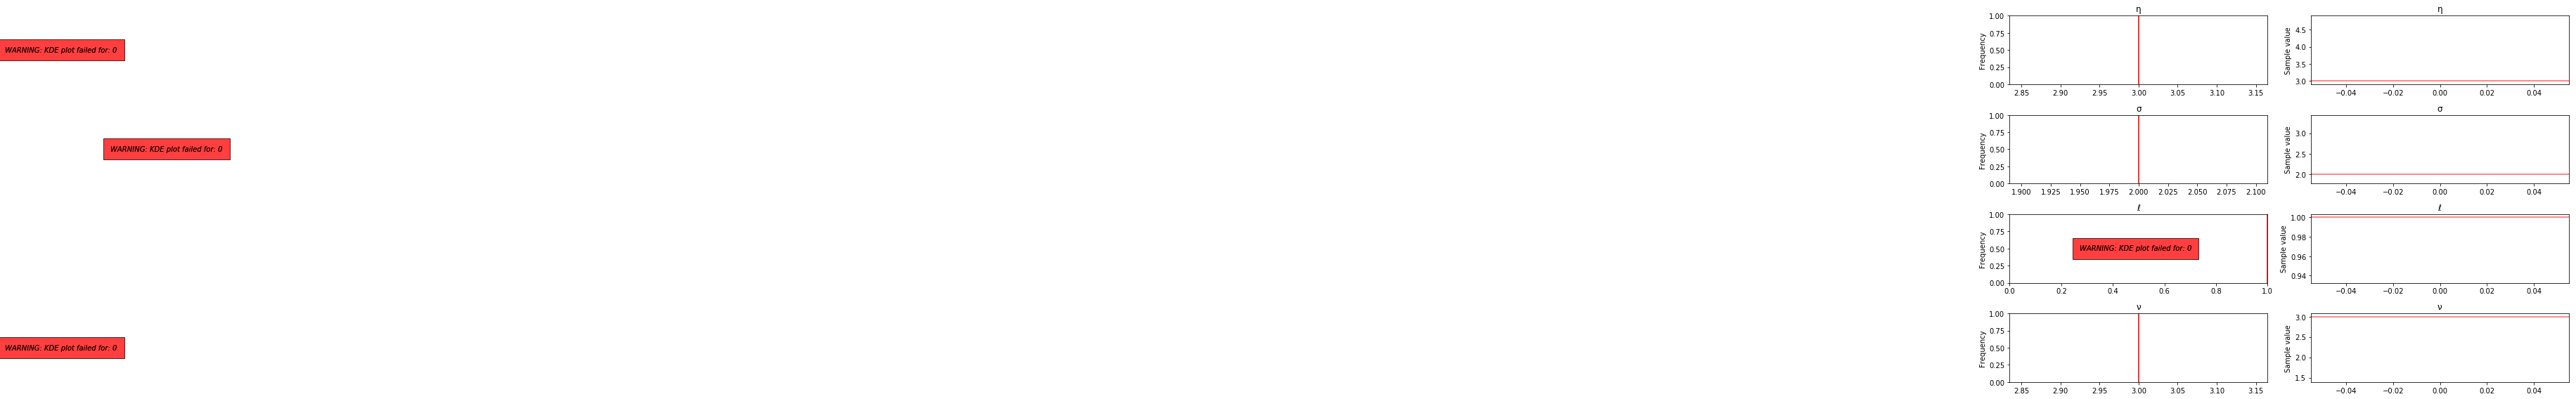

In [87]:
pm.traceplot(trace, lines={"η": η_true, "σ": σ_true, "ℓ": ℓ_true, "ν": ν_true}, varnames=["η", "σ", "ℓ", "ν"]);

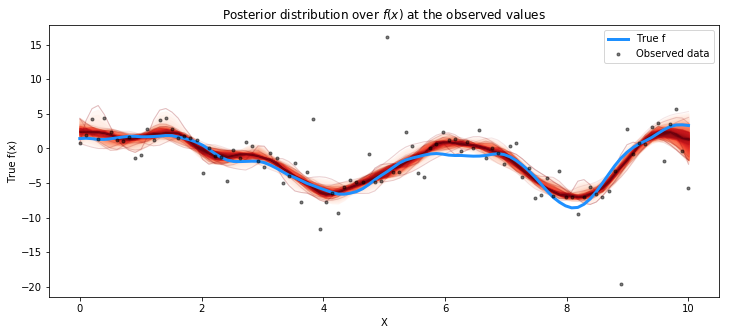

In [5]:
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, trace["f"], X);

# plot the data and the true latent function
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("X"); plt.ylabel("True f(x)");
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();

In [6]:
# 200 new values from x=0 to x=15
n_new = 200
X_new = np.linspace(0, 15, n_new)[:,None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", X_new)

# Sample from the GP conditional distribution
with model:
    pred_samples = pm.sample_posterior_predictive(trace, vars=[f_pred], samples=1000)



100%|██████████| 1000/1000 [01:19<00:00, 12.57it/s]


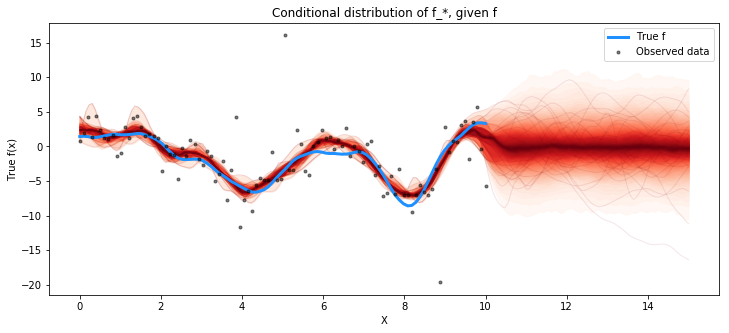

In [7]:

# plot the results

fig = plt.figure(figsize=(12,5)); ax = fig.gca()
plot_gp_dist(ax, pred_samples["f_pred"], X_new);
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");
plt.xlabel("X"); plt.ylabel("True f(x)");
plt.title("Conditional distribution of f_*, given f"); plt.legend();

{'f_pred': array([[ 3.40192797,  3.45024769,  3.4136014 , ...,  2.39702219,
          3.29866343,  4.04188717],
        [ 2.88494901,  2.52414298,  2.26525973, ..., -4.3606087 ,
         -4.37894503, -4.42346404],
        [ 2.46457777,  2.46536618,  2.47215747, ...,  0.40306602,
          1.17408017,  1.78609591],
        ...,
        [ 4.22996617,  3.79557982,  3.35966153, ..., -2.18671487,
         -2.45004651, -2.89640482],
        [ 2.8789624 ,  2.60649128,  2.48169832, ..., -2.90329394,
         -2.74128724, -2.72869213],
        [ 3.25770365,  3.09712956,  3.07255078, ...,  0.32208833,
          0.4420627 ,  0.48311644]])}

### Trying GPflow
    - tf implementation of GPy
    - faster and better for larger models
    
    - mostly using this in the project
    - train a B-GPLVM on some data and show results
    - repeat on MNIST
    - reproduce some results--> class separation etc

In [112]:
import gpflow as gp

In [5]:
import gpflow
from gpflow import kernels
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
np.random.seed(42)
gpflow.settings.numerics.quadrature = 'error'  # throw error if quadrature is used for kernel expectations

In [17]:

data = np.loadtxt('data/DataTrn.txt')
labels_ = np.loadtxt("data/DataTrnLbls.txt")
Y = data
# labels = data['labels']

# print('Number of points x Number of dimensions', Y.shape)


In [8]:
Q = 5
M = 20  # number of inducing pts
N = Y.shape[0]
X_mean = gpflow.models.PCA_reduce(Y, Q) # Initialise via PCA
Z = np.random.permutation(X_mean.copy())[:M]

fHmmm = False
if(fHmmm):
    k = (kernels.RBF(3, ARD=True, active_dims=slice(0,3)) +
         kernels.Linear(2, ARD=False, active_dims=slice(3,5)))
else:
    k = (kernels.RBF(3, ARD=True, active_dims=[0,1,2]) +
         kernels.Linear(2, ARD=False, active_dims=[3, 4]))

m = gpflow.models.BayesianGPLVM(X_mean=X_mean, X_var=0.1*np.ones((N, Q)), Y=Y,
                                kern=k, M=M, Z=Z)
m.likelihood.variance = 0.01

opt = gpflow.train.ScipyOptimizer()
m.compile()
opt.minimize(m, maxiter=gpflow.test_util.notebook_niter(10000))

/home/arnav/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -5535.574334
  Number of iterations: 1663
  Number of functions evaluations: 1767


INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -5535.574334
  Number of iterations: 1663
  Number of functions evaluations: 1767


In [9]:
m.kern.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
BayesianGPLVM/kern/kernels/0/lengthscales,Parameter,None,+ve,True,"(3,)",True,"[5.717519832562978, 69.94117024188954, 1.61438..."
BayesianGPLVM/kern/kernels/0/variance,Parameter,None,+ve,True,(),True,21.638272060813293
BayesianGPLVM/kern/kernels/1/variance,Parameter,None,+ve,True,(),True,0.027213507953804825


In [10]:
kern = m.kern.kernels[0]
sens = np.sqrt(kern.variance.read_value())/kern.lengthscales.read_value()
print(sens)

[0.81358627 0.06650869 2.88141104]


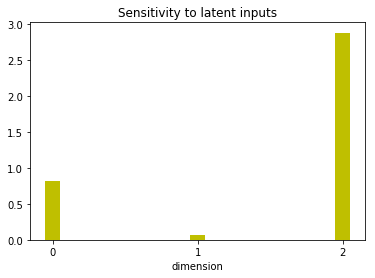

In [11]:
fig, ax = plt.subplots()
dims = np.arange(len(sens))
ax.bar(dims, sens, 0.1, color='y')
ax.set_xticks(dims)
ax.set_xlabel('dimension')
ax.set_title('Sensitivity to latent inputs');

In [12]:
dim1, dim2 = sens.argsort()[::-1][:2]  # the two dimensions with highest sensitivity

In [19]:
labels = [l.argmax() for l in labels_]

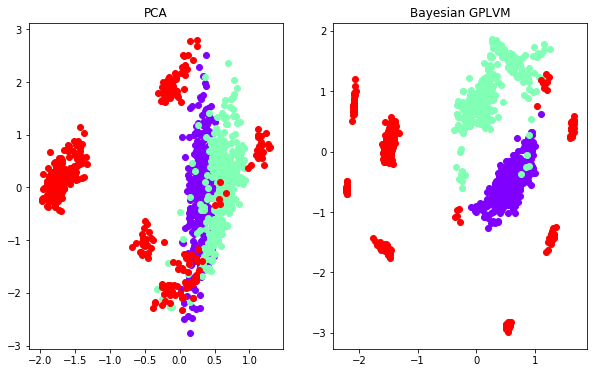

In [23]:
XPCAplot = gpflow.models.PCA_reduce(Y, 2)
GPLVM_X_mean = m.X_mean.read_value()

f, ax = plt.subplots(1,2, figsize=(10,6))
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(labels))))

for i, c in zip(np.unique(labels), colors):
    ax[0].scatter(XPCAplot[labels==i, 0], XPCAplot[labels==i, 1], color=c, label=i)
    ax[0].set_title('PCA')
    ax[1].scatter(GPLVM_X_mean[labels==i, dim1], GPLVM_X_mean[labels==i, dim2], color=c, label=i)
    ax[1].set_title('Bayesian GPLVM')

## TODO:
    - evaluation of representations code
    - same on mnist
    - partially obdserverd reconstructions
    

In [54]:
# reconstruction error based only on the mean predictions
# mean Y | X
((m.predict_y(GPLVM_X_mean[:,:])[0] - Y[:,:])**2).sum(axis = 1).mean()

0.01900653752975054

In [55]:
# f | x
m.predict_f(GPLVM_X_mean[0].reshape(1,5))

(array([[0.31762794, 0.15113056, 0.64923904, 0.21047601, 0.72054584,
         0.24760859, 0.66996562, 0.20628934, 0.74849885, 0.24887449,
         0.59426458, 0.18852404]]),
 array([[5.46845812e-05, 5.46845812e-05, 5.46845812e-05, 5.46845812e-05,
         5.46845812e-05, 5.46845812e-05, 5.46845812e-05, 5.46845812e-05,
         5.46845812e-05, 5.46845812e-05, 5.46845812e-05, 5.46845812e-05]]))

In [67]:
##log lokelihood of Y_new | x_new
m.predict_density(GPLVM_X_mean[1].reshape(1,5), Y[0].reshape(1,12)).sum()

-570.6220406957914

In [57]:
GPLVM_X_mean[0]

array([-1.14369628, -0.01698357,  0.37374261,  0.02351539, -0.78905761])

In [68]:
## find X_new | Y_new ??


### same on MNIST

In [1]:
import gpflow
from gpflow import kernels
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
np.random.seed(42)
gpflow.settings.numerics.quadrature = 'error' 
import torch, torchvision
import torchvision.transforms as transforms
root = './data'
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

In [2]:
from tqdm import tqdm_notebook as tqdm

In [3]:
MNIST_train = torchvision.datasets.MNIST(root=root, train=True, transform=trans, download=True)
MNIST_test  = torchvision.datasets.MNIST(root=root, train=False, transform=trans, download=True)

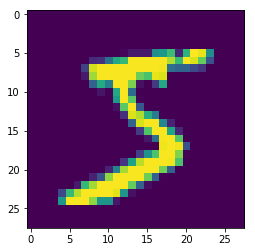

In [4]:
plt.imshow(MNIST_train[0][0].reshape(28,28))

(<matplotlib.image.AxesImage at 0x7f69add26fd0>, tensor(7))

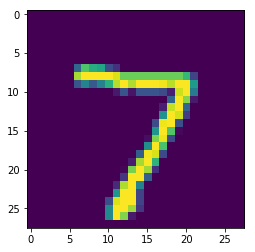

In [5]:
plt.imshow(MNIST_test[0][0].reshape(28,28)), MNIST_test[0][1]

In [6]:
 MNIST_train[0][1]

tensor(5)

In [7]:
x = []
labels = []
for t, l in MNIST_train:
    x.append(t.numpy().flatten())
    labels.append(l)

In [8]:
x = np.array(x)
labels = np.array(labels)

In [9]:
x.shape

(60000, 784)

In [10]:
x_3 = x[np.where(labels <= 2)]
l_3 = labels[np.where(labels <= 2)]

In [11]:
Y = x_3.astype(np.float64)
Y.shape

(18623, 784)

In [12]:
del x

In [ ]:
Q = 50
M = 20  # number of inducing pts
N = Y.shape[0]
X_mean = gpflow.models.PCA_reduce(Y, Q) # Initialise via PCA
Z = np.random.permutation(X_mean.copy())[:M]

fHmmm = False
if(fHmmm):
    k = (kernels.RBF(3, ARD=True, active_dims=slice(0,3)) +
         kernels.Linear(2, ARD=False, active_dims=slice(3,5)))
else:
    k = (kernels.RBF(3, ARD=True, active_dims=[0,1,2]) +
         kernels.Linear(2, ARD=False, active_dims=[3, 4]))

m = gpflow.models.BayesianGPLVM(X_mean=X_mean, X_var=0.1*np.ones((N, Q)), Y=Y,
                                kern=k, M=M, Z=Z)
m.likelihood.variance = 0.01

opt = gpflow.train.ScipyOptimizer()
m.compile()
opt.minimize(m, maxiter=gpflow.test_util.notebook_niter(10))
print("done")

/home/arnav/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [ ]:
m.kern.as_pandas_table()

In [ ]:
kern = m.kern.kernels[0]
sens = np.sqrt(kern.variance.read_value())/kern.lengthscales.read_value()
print(sens)

In [ ]:
fig, ax = plt.subplots()
dims = np.arange(len(sens))
ax.bar(dims, sens, 0.1, color='y')
ax.set_xticks(dims)
ax.set_xlabel('dimension')
ax.set_title('Sensitivity to latent inputs');

In [ ]:
dim1, dim2 = sens.argsort()[::-1][:2] 

In [ ]:
XPCAplot = gpflow.models.PCA_reduce(Y, 2)
GPLVM_X_mean = m.X_mean.read_value()

f, ax = plt.subplots(1,2, figsize=(10,6))
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(l_3))))

for i, c in zip(np.unique(labels), colors):
    ax[0].scatter(XPCAplot[l_3==i, 0], XPCAplot[l_3==i, 1], color=c, label=i)
    ax[0].set_title('PCA')
    ax[1].scatter(GPLVM_X_mean[l_3==i, dim1], GPLVM_X_mean[l_3==i, dim2], color=c, label=i)
    ax[1].set_title('Bayesian GPLVM')

In [ ]:
def reconstruct(i):
    y = m.predict_y(GPLVM_X_mean[i].reshape(1,50))[0]

    plt.imshow(y.reshape(28,28))
    plt.savefig("reconstruction"+str(i) + ".png")
    plt.figure()
    plt.imshow(Y[i].reshape(28,28))
    plt.savefig("actual" +str(i) + ".png")
reconstruct(i=0)

In [ ]:
GPLVM_X_mean[0].shape